In [2]:
import socket
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hashlib
from threading import Thread, Lock
entry_number = "2021CS10556";
team_name = "majorlazor";
teamid = entry_number + "@" + team_name;

In [3]:
# url = "10.184.57.25"; #Tejas
url = "10.17.7.134"; #Vayu
max_bytes = 1448; 
max_bytes_with_headers = 2048;
chunk_size = 1448;
port = 9801; 
time_out = 0.01; 
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # internet and UDP
sock.setblocking(0); #non-blocking
sock.settimeout(time_out);
sendsize = "SendSize\n\n".encode(); 
is_getting_squished = False; 


def get_size(s:socket.socket, also_reset = False):
    if(also_reset == False):
        s.sendto(sendsize, (url,port));
    else:
        s.sendto("SendSize\nReset\n\n".encode(), (url,port));
    try:
        data, addr = s.recvfrom(max_bytes_with_headers);     '''data of the form str 'Size: [number of bytes]\n\n' '''
        data = data.decode();
        num_data = data[6:]; #from after the size: 
        bytes_to_receive = 0
        for i in range(len(num_data)):
            if(num_data[i]=='\n'): 
                bytes_to_receive = int(num_data[:i])
                break;
        return bytes_to_receive;
    except Exception as e:
        return None; #packet probably dropped.

def get_request_message(offset,num_bytes=max_bytes):
    return ("Offset: " + str(offset) + "\n" + "NumBytes: " + str(num_bytes) + "\n\n").encode(); 
def send_reset(s:socket.socket):
    s.sendto("Reset\n\n".encode(), (url,port));

def get_received_data(s : socket.socket, upto_bytes = 1800):
    try:
        data, addr = s.recvfrom(upto_bytes); 
        # if(type(data) == bytes):
        data = data.decode(); 
        offset = 0; Num_bytes = 0;
        for i in range(len(data)):
            if(data[i] == '\n'):
                offset = int(data[8:i]);
                data = data[i+1:]; # Possible improvement 
                break;
        for i in range(len(data)):
            if(data[i] == '\n'):
                Num_bytes = int(data[10:i]);
                if(data[i+1] != '\n'):
                    raise Exception("Error in get_received_data: data[i+1] != '\\n', data= ", data);
                data = data[i+2:]; # Possible improvement
                break;
        #now this next part is the actual data
        squished = "Squished\n\n";
        global is_getting_squished; #determines if we are getting squished. 
        if(data[:len(squished)] == squished):
            is_getting_squished = True; 
            print("GETTING SQUISHED YO")
            data = data[len(squished):];
        else:
            is_getting_squished = False;

    except Exception as e:
        return None,None,None; 
    
    return offset, Num_bytes, data;
    #if data has more than 1 element, then it has responses of multiple requests, 
    #which miiiight be a problem if our recv function doesn't take the entire message at once.
def reliable_sequential_data_transfer(s: socket.socket, delay=0.01):
    bytes_to_receive = None; 
    while(bytes_to_receive == None):
        bytes_to_receive = get_size(s);
        if(bytes_to_receive == None):
            print("Couldn't receive size in time, trying again."); 
            time.sleep(delay);
    # Now we will start sending data requests
    curr_offset = 0
    data_array = [] # data will arrive sequentially so we can store it in an array
    request_arr = [[],[]];
    receive_arr = [[],[]];
    start = time.time()
    fails = 0; passes = 0;
    print("total bytes to receive: ", bytes_to_receive); 
    while(bytes_to_receive > 0):
        s.sendto(get_request_message(curr_offset), (url,port)); 
        request_arr[0].append((time.time()-start));
        request_arr[1].append(curr_offset);
        try:
            rcvd_offset, rcvd_num_bytes, rcvd_data = get_received_data(s, max_bytes_with_headers)
            if(rcvd_offset == None):
                fails += 1; 
                continue; 
            passes += 1; 
            assert(rcvd_offset == curr_offset)
            curr_offset += chunk_size
            bytes_to_receive -= rcvd_num_bytes
            data_array.append(rcvd_data)
            receive_arr[0].append((time.time()-start));
            receive_arr[1].append(rcvd_offset);
            #print("bytes to receive: ", bytes_to_receive, "offset: ", rcvd_offset, "num_bytes: ", rcvd_num_bytes); 
            time.sleep(delay)
        except Exception as e:
            print("exception raised ", e);
            print();
            raise e; 
    if(data_array[-1][-1] == '\x00'):
        data_array[-1] = data_array[-1][:-1];
    string_data = ''.join(data_array)
    print("Total fails: ", fails, "Total passes: ", passes);
    return string_data, request_arr, receive_arr, (time.time()-start);

def bursty_reliable_data_transfer(s:socket.socket, timeout=0.5, initial_burst_rate=7, sleep_time=0.15):
    start_time = time.time();
    bytes_to_receive = None; 
    while(bytes_to_receive == None):
        bytes_to_receive = get_size(s);
        if(bytes_to_receive == None):
            print("here")
            print("Couldn't receive size in time, trying again."); 
            time.sleep(timeout);
    # Now we will start sending data requests
    #we need to send the data requests in bursts 
    total_chunks = bytes_to_receive//chunk_size + 1 if bytes_to_receive%chunk_size != 0 else bytes_to_receive//chunk_size;
    missed_list = [i for i in range(total_chunks)]; 
    burst_size = initial_burst_rate; 
    missed_set = set(missed_list); 
    data_array = [None for i in range(total_chunks)];
    request_arr = [[],[]]; 
    receive_arr = [[],[]]; 
    start = time.time(); 
    fails = 0; total_requests = 0;
    iter = 0; 
    while(len(missed_set) > 0):
        missed_list = list(missed_set); 
        #now we will send bursts of requests.
        i = 0; 
        while(i < len(missed_list)):
            cur_fails = 0; cur_requests = 0;
            for j in range(burst_size):
                if(i+j >= len(missed_list)):
                    break; 
                s.sendto(get_request_message(missed_list[i+j]*chunk_size), (url,port)); 
                request_arr[0].append((time.time()-start)); 
                request_arr[1].append(missed_list[i+j]*chunk_size); 
                cur_requests+=1; 
            #now we will wait for the responses
            for j in range(burst_size):
                if(i+j >= len(missed_list)):
                    break; 
                try:
                    rcvd_offset, rcvd_num_bytes, rcvd_data = get_received_data(s, max_bytes_with_headers)
                    if(rcvd_offset == None):
                        cur_fails += 1;
                        continue;
                    pos = rcvd_offset//chunk_size;
                    receive_arr[0].append((time.time()-start)); 
                    receive_arr[1].append(rcvd_offset);  
                    if(pos in missed_set):
                        missed_set.remove(pos); 
                    data_array[pos] = rcvd_data; 
                except Exception as e:
                    print("exception raised ", e);
                    raise e; 
            # if(cur_fails > 0):
            #     print("for i = ", i, "cur_fails = ", cur_fails, "cur_requests = ", cur_requests);
            i += burst_size; 
            fails += cur_fails; 
            total_requests += cur_requests; 
            if(iter%(total_chunks/100) == 0):
                print("stats:", iter, " iterations, ", total_requests, " requests made, ", fails, " failed.", "missed_set size: ", len(missed_set)); 
            iter += 1; 
            time.sleep(sleep_time); 
    if(data_array[-1][-1] == '\x00'):
        data_array[-1] = data_array[-1][:-1];
    complete_file  = ''.join(data_array); 
    print(total_requests, " requests made, ", fails, " failed.");
    end_time = time.time(); 
    return complete_file, request_arr, receive_arr, (end_time-start_time);    

def AIMD_transfer(s: socket.socket, sleep_time = 0.1,initial_rate = 1,additive_factor=1,multiplicative_factor=0.5):
    start_time = time.time();
    bytes_to_receive = None; 
    while(bytes_to_receive == None):
        bytes_to_receive = get_size(s);
        if(bytes_to_receive == None):
            print("here")
            print("Couldn't receive size in time, trying again."); 
            time.sleep(sleep_time);
    lower_bound_rate = 1; upper_bound_rate = 50; burst_size = initial_rate; 
    total_chunks = bytes_to_receive//chunk_size + 1 if bytes_to_receive%chunk_size != 0 else bytes_to_receive//chunk_size;
    missed_list = [i for i in range(total_chunks)]; missed_set = set(missed_list); 
    data_array = [None for i in range(total_chunks)];
    request_arr = [[],[]]; receive_arr = [[],[]]; 
    start = time.time(); prev = start; 
    fails = 0; total_requests = 0; iter = 0; 
    stats = dict(); #Stats stores a list of size 2 for each burst_size. The first saying the number of fails, and the second saying the number of requests of that type.
    average_failure_rate = [3,30,0.1]; #This stores the average failure rate. This can be assumed to be the random dropping chance. First variable is number of fails, second is number of requests, and third is their division. 
    #We initialize this as 10% dropping rate, but it can change on its own to the current value with time. 
    while(len(missed_set) > 0):
        missed_list = list(missed_set); 
        #now we will send bursts of requests.
        i = 0; 
        while(i < len(missed_list)):
            #print("time gap: ", time.time()-prev, " average failure rate: ", average_failure_rate[2]);
            prev = time.time();
            #print("Burst rate: ", burst_size,"Lower bound rate: ", lower_bound_rate, "Upper bound rate: ", upper_bound_rate);
            cur_fails = 0; cur_requests = 0;
            for j in range(burst_size):
                if(i+j >= len(missed_list)):
                    break; 
                s.sendto(get_request_message(missed_list[i+j]*chunk_size), (url,port)); 
                request_arr[0].append((time.time()-start)); 
                request_arr[1].append(missed_list[i+j]*chunk_size); 
                cur_requests+=1; 
            #now we will wait for the responses
            for j in range(burst_size):
                if(i+j >= len(missed_list)):
                    break; 
                try:
                    rcvd_offset, rcvd_num_bytes, rcvd_data = get_received_data(s, max_bytes_with_headers)
                    if(rcvd_offset == None):
                        cur_fails += 1;
                        continue;
                    pos = rcvd_offset//chunk_size;
                    receive_arr[0].append((time.time()-start)); 
                    receive_arr[1].append(rcvd_offset);  
                    if(pos in missed_set):
                        missed_set.remove(pos); 
                    data_array[pos] = rcvd_data; 
                except Exception as e:
                    print("exception raised ", e);
                    raise e; 
            # if(cur_fails > 0):
            #     print("for i = ", i, "cur_fails = ", cur_fails, "cur_requests = ", cur_requests);
            i += burst_size; 
            fails += cur_fails; 
            total_requests += cur_requests; 
            if(iter%(total_chunks/100) == 0):
                print("stats:", iter, " iterations, ", total_requests, " requests made, ", fails, " failed.", "missed_set size: ", len(missed_set)); 
            iter += 1; 
            if burst_size not in stats:
                stats[burst_size] = [0,0]; 
            stats[burst_size][0] += cur_fails; stats[burst_size][1] += 1; #Number of fails and number of requests for th
            average_failure_rate[0] += cur_fails; average_failure_rate[1] += cur_requests; average_failure_rate[2] = average_failure_rate[0]/average_failure_rate[1]; 
            cur_failure_rate = stats[burst_size][0]/(burst_size*stats[burst_size][1]); 
            #we will calculate the averaeg failure rate using weighted average, with weights proportional to 1/burst_size. 
            keys = list(stats.keys()); 
            total = 0;
            for key in keys:
                total += 1/key;
            average_failure_rate[2] = 0; 
            for key in keys:
                average_failure_rate[2] += (1/key)/total * stats[key][0]/(key*stats[key][1]);
            if(is_getting_squished):
                burst_size = lower_bound_rate*multiplicative_factor; #After this, due to curfails we will again lower the burst size by multiplicative factor.
                lower_bound_rate = 1; #Resetting our lower bound.       
                print("GOT SQUISHED, LOWERING BURST SIZE TO ", burst_size);  
            
            elif((cur_failure_rate >= 1.5*average_failure_rate[2] and stats[burst_size][1] >= 5) or (cur_failure_rate >= 1.25*average_failure_rate[2] and stats[burst_size][1] >= 10)): #That is,if we fail more than 1.5 times the current average failure rate.
                if(stats[burst_size][1] >= 15):
                    upper_bound_rate = max(1,burst_size-1); 
                burst_size = min(max(lower_bound_rate,int(burst_size*multiplicative_factor)), upper_bound_rate);
                if(lower_bound_rate > upper_bound_rate):
                    lower_bound_rate = max(1,upper_bound_rate - 1); 
            
            elif(cur_fails == 0 or (stats[burst_size][0]/(burst_size*stats[burst_size][1]) <= 1.1 * average_failure_rate[2] and stats[burst_size][1] >= 2)): 
                if(stats[burst_size][1] >= 10):
                    lower_bound_rate = max(burst_size, lower_bound_rate); #We can get data at this rate so we can increase the lower bound.
                burst_size = min(upper_bound_rate, burst_size+additive_factor);
            print("stats: ", stats); 
            time.sleep(max(0, sleep_time - (time.time()-prev))); #subtracting the time elapsed in the loop from the sleep time to maintain a constant sleep time. 
    if(data_array[-1][-1] == '\x00'):
        data_array[-1] = data_array[-1][:-1];
    complete_file  = ''.join(data_array); 
    print(total_requests, " requests made, ", fails, " failed.");
    end_time = time.time(); 
    print("stats: ", stats); 
    return complete_file, request_arr, receive_arr, (end_time-start_time), stats;    

In [4]:
def bursty_reliable_data_transfer_with_threading(s:socket.socket, timeout=0.04, initial_burst_rate=7, sleep_time=0.15, reset = False):
    start_time = time.time();
    bytes_to_receive = None; 
    while(bytes_to_receive == None):
        bytes_to_receive = get_size(s, reset);
        if(bytes_to_receive == None):
            print("Couldn't receive size in time, trying again."); 
            time.sleep(timeout);
    # Now we will start sending data requests
    #we need to send the data requests in bursts 
    total_chunks = bytes_to_receive//chunk_size + 1 if bytes_to_receive%chunk_size != 0 else bytes_to_receive//chunk_size;
    missed_list = [i for i in range(total_chunks)]; 
    burst_size = initial_burst_rate; 
    missed_set = set(missed_list); 
    data_array = [None for i in range(total_chunks)];
    request_arr = [[],[]]; 
    receive_arr = [[],[]]; 
    start = time.time(); 
    fails = 0; total_requests = 0; 
    lock_set = Lock(); 
    squish_periods = [[],[]]; 
    def send_burst(send_sleep_time = 0.15,burst_size = 7):
        missed_list = list(missed_set); 
        #now we will send bursts of requests.
        remaining_size = len(missed_set);
        while(remaining_size > 0):
            i = 0; 
            missed_list = list(missed_set);
            while(i < len(missed_list)):
                cur_fails = 0; cur_requests = 0;
                for j in range(burst_size):
                    if(i+j >= len(missed_list)):
                        break; 
                    s.sendto(get_request_message(missed_list[i+j]*chunk_size), (url,port)); 
                    request_arr[0].append((time.time()-start)); 
                    request_arr[1].append(missed_list[i+j]*chunk_size); 
                    cur_requests+=1; 
                time.sleep(send_sleep_time);
                i += burst_size;
            remaining_size = len(missed_set);
    def receive_bursts(rec_sleep_time = 0.15,burst_size = 7):
        remaining_size = len(missed_set);
        total_requests = 0;
        fails = 0;
        while(remaining_size > 0):
            cur_fails = 0;
            for _ in range(burst_size):
                try:
                    rcvd_offset, rcvd_num_bytes, rcvd_data = get_received_data(s, max_bytes_with_headers)
                    if(rcvd_offset == None):
                        cur_fails += 1;
                        continue;
                    pos = rcvd_offset//chunk_size;
                    receive_arr[0].append((time.time()-start)); 
                    receive_arr[1].append(rcvd_offset);
                    squish_periods[0].append((time.time()-start));
                    squish_periods[1].append(1 if is_getting_squished else 0);  
                    with lock_set:
                        if(pos in missed_set):
                            missed_set.remove(pos); 
                    data_array[pos] = rcvd_data; 
                except Exception as e:
                    print("exception raised ", e);
                    raise e; 
            time.sleep(rec_sleep_time);
            remaining_size = len(missed_set);
            total_requests += burst_size;
            fails += cur_fails;
            print("stats:", total_requests, " requests made, ", fails, " failed.", "missed_set size: ", remaining_size, end = "\r"); 

    send_thread = Thread(target=send_burst,args=(sleep_time,burst_size)); 
    receive_thread = Thread(target=receive_bursts,args=(sleep_time,burst_size)); 
    send_thread.start()
    receive_thread.start()
    receive_thread.join()
    if(data_array[-1][-1] == '\x00'):
        data_array[-1] = data_array[-1][:-1]; 
    complete_file  = ''.join(data_array); 
    print(total_requests, " requests made, ", fails, " failed.");
    end_time = time.time(); 
    return complete_file, request_arr, receive_arr, (end_time-start_time), squish_periods;    


In [18]:
x = 5
def AIMD_reliable_data_transfer(s:socket.socket, timeout=0.08, initial_burst_rate=7, sleep_time=0.15, reset = False, min_burst_size=5):
    start_time = time.time();
    bytes_to_receive = None; 
    while(bytes_to_receive == None):
        bytes_to_receive = get_size(s, reset);
        if(bytes_to_receive == None):
            print("Couldn't receive size in time, trying again."); 
            time.sleep(timeout);
    # Now we will start sending data requests
    #we need to send the data requests in bursts 
    total_chunks = bytes_to_receive//chunk_size + 1 if bytes_to_receive%chunk_size != 0 else bytes_to_receive//chunk_size;
    missed_list = [i for i in range(total_chunks)]; 
    burst_size = initial_burst_rate; max_burst_size = 1000;
    missed_set = set(missed_list); 
    data_array = [None for i in range(total_chunks)];
    request_arr = [[],[]]; 
    receive_arr = [[],[]]; 
    burst_sizes = [[],[]]; 
    squish_periods = [[],[]]; 
    ewma_rtt_arr = [[],[]]; 
    rtt_arr = [[],[]]; 
    start = time.time(); 
    fails = 0; total_requests = 0;
    lock_set = Lock(); timeout_const_multiplier = 2.2; 
    def send_burst(send_sleep_time = 0.15,burst_size = 7):
        missed_list = list(missed_set); 
        #now we will send bursts of requests.
        remaining_size = len(missed_set);
        lambda_weight = 0.1; rtt = 0.25; ewma_rtt = 0.008; 
        while(remaining_size > 0):
            i = 0; 
            missed_list = list(missed_set);
            s.settimeout(x*0.00255); 
            while(i < len(missed_list)):
                cur_fails = 0; cur_requests = 0;
                start_burst = time.time(); 
                first_req_sent_time = 0;
                for j in range(0,int(burst_size)):
                    if(i+j >= len(missed_list)):
                        break; 
                    s.sendto(get_request_message(missed_list[i+j]*chunk_size), (url,port)); 
                    if(j == 0):
                        first_req_sent_time = time.time();
                    request_arr[0].append((time.time()-start)); 
                    request_arr[1].append(missed_list[i+j]*chunk_size); 
                    cur_requests+=1; 
                cur_fails, first_req_recv_time = receive_bursts(int(burst_size)); 
                time.sleep(max(0,send_sleep_time - (time.time() - start_burst))); 
                i += burst_size; 
                if(cur_fails >= 1):
                    burst_size = max(min_burst_size,int(burst_size/1.7));
                else:
                    burst_size = min(burst_size+1, max_burst_size);
                burst_sizes[0].append((time.time()-start)); burst_sizes[1].append(burst_size);
                 
                if(first_req_recv_time != 0):
                    rtt = first_req_recv_time - first_req_sent_time; 
                    if(rtt != 0):
                        ewma_rtt = (rtt*lambda_weight) + ewma_rtt*(1-lambda_weight); 
                        ewma_rtt_arr[0].append((time.time()-start)); ewma_rtt_arr[1].append(ewma_rtt);
                        rtt_arr[0].append((time.time()-start)); rtt_arr[1].append(rtt);
                
                squish_periods[0].append((time.time()-start)); squish_periods[1].append(1 if is_getting_squished else 0);
                print("burst size: ", burst_size, "remaining: ", len(missed_set), "RTT:",rtt, "ewma_RTT", ewma_rtt,end = "\r");
            remaining_size = len(missed_set); 
    def receive_bursts(burst_size = 7):
        cur_fails = 0; 
        first_req_receive_time = 0; 
        for i in range(burst_size):
            try:
                rcvd_offset, rcvd_num_bytes, rcvd_data = get_received_data(s, max_bytes_with_headers)
                if(rcvd_offset == None):
                    cur_fails += 1; 
                    continue; 
                if(i == 0):
                    first_req_receive_time = time.time();
                pos = rcvd_offset//chunk_size;
                receive_arr[0].append((time.time()-start)); 
                receive_arr[1].append(rcvd_offset);  
                with lock_set:
                    if(pos in missed_set):
                        missed_set.remove(pos); 
                        data_array[pos] = rcvd_data; 
                    else:
                        print("duplicate received"); 
            except Exception as e:
                print("exception raised ", e); 
                raise e; 
        return cur_fails, first_req_receive_time; 

    send_burst(sleep_time,int(burst_size)); 
    if(data_array[-1][-1] == '\x00'):
        data_array[-1] = data_array[-1][:-1];
    complete_file  = ''.join(data_array); 
    print(total_requests, " requests made, ", fails, " failed.");
    end_time = time.time(); 
    return complete_file, request_arr, receive_arr, (end_time-start_time), burst_sizes, squish_periods, ewma_rtt_arr, rtt_arr;    

In [16]:
def self_clocking(s:socket.socket, cwnd=7, sleep_time=0.05):
    #cwnd is the congestion window size. 
    start_time = time.time(); 
    bytes_to_receive = None; 
    while(bytes_to_receive == None):
        bytes_to_receive = get_size(s); 
        if(bytes_to_receive == None):
            print("Couldn't receive size in time, trying again."); 
    total_chunks = bytes_to_receive//chunk_size + 1 if bytes_to_receive%chunk_size != 0 else bytes_to_receive//chunk_size;
    missed_list = [i for i in range(total_chunks)]; 
    burst_size = cwnd;  
    missed_set = set(missed_list); 
    data_array = [None for i in range(total_chunks)]; 
    
    #We maintain a constant congestion window 

In [19]:
complete_file, request_arr, receive_arr, time_taken, burst_sizes, squish_periods, ewma_rtt_arr, rtt_arr = AIMD_reliable_data_transfer(sock,sleep_time=0.03,initial_burst_rate=10, reset=True, min_burst_size=6);

# To ensure there is no data remaining.
# try:
    # print(get_received_data(sock, 1800));
# except Exception as e:
    # print(e); 

def submit_data(s:socket.socket, complete_data):
    md5 = hashlib.md5(complete_data.encode()).hexdigest();
    submit_val = "Submit: " + teamid + "\n" + "MD5: " + md5 + "\n\n";
    s.sendto((submit_val).encode(), (url, port));
    while(True):
        try:
            result,addr = s.recvfrom(1800);
        except:
            continue;
        break;
    result = result.decode();
    return result;
print(submit_data(sock, complete_file));   
print("total time taken: ",time_taken); 

0  requests made,  0  failed.RTT: 0.006065845489501953 ewma_RTT 0.00624997685336497495525
Result: true
Time: 13436
Penalty: 12


total time taken:  13.424221992492676


In [192]:
#Constant version with threads. Burst rate is optimally decided and is constant.
complete_file, request_arr, receive_arr, time_taken, squish_periods = bursty_reliable_data_transfer_with_threading(sock,sleep_time=0.03,initial_burst_rate=8, reset = True); 

print(submit_data(sock, complete_file));   
print("total time taken: ",time_taken); 

KeyboardInterrupt: 

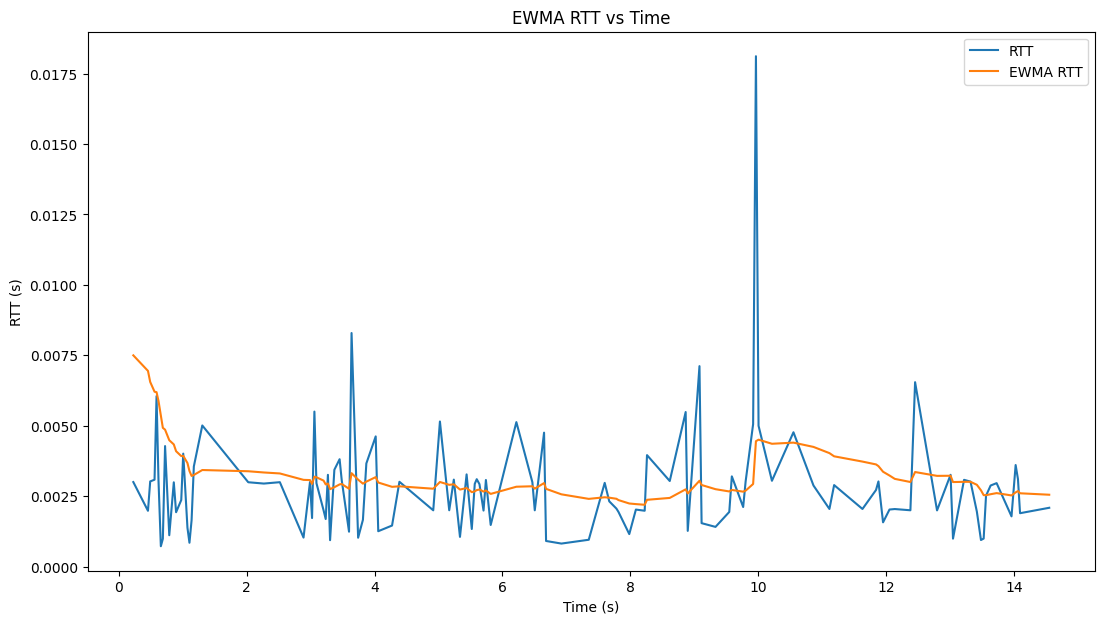

In [194]:
fig,ax = plt.subplots(figsize=(13,7));
ax.plot(rtt_arr[0], rtt_arr[1], label="RTT");
ax.plot(ewma_rtt_arr[0],ewma_rtt_arr[1],label="EWMA RTT"); 
ax.set_title("EWMA RTT vs Time");
ax.set_xlabel("Time (s)"); ax.set_ylabel("RTT (s)");
ax.legend();
plt.show();

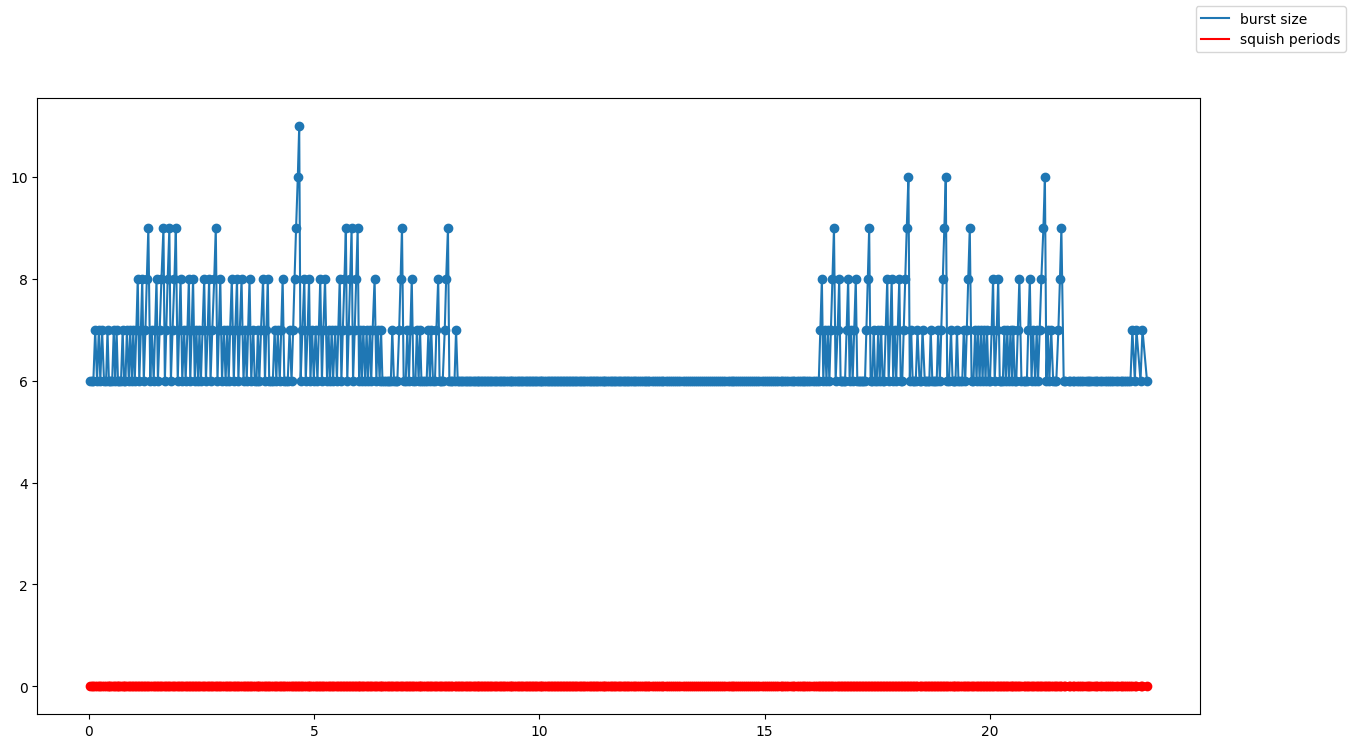

In [184]:
fig, ax = plt.subplots(figsize=(15,8));
# burst_sizes[1] = [8 for i in range(len(burst_sizes[0]))]
ax.plot(burst_sizes[0], burst_sizes[1], label="burst size");
ax.scatter(burst_sizes[0], burst_sizes[1]); 
ax.plot(squish_periods[0], squish_periods[1], label = "squish periods", color='r');
ax.scatter(squish_periods[0], squish_periods[1], color='r'); 
fig.legend()

In [60]:
try:
    print(get_received_data(sock, 1800));
except Exception as e:
    print(e); 

(None, None, None)


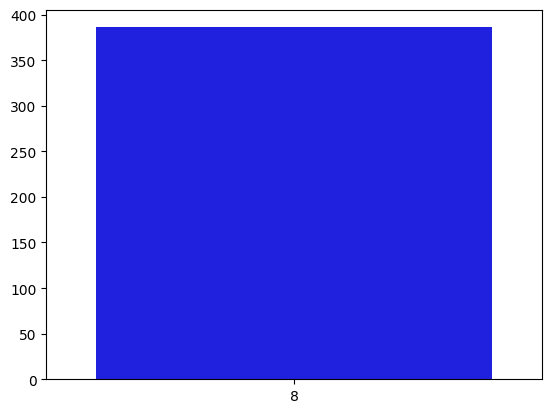

In [109]:
import seaborn as sns; 
stats = dict(); 
for x in burst_sizes[1]:
    if(x not in stats):
        stats[x] = 0; 
    stats[x] += 1;
keys = list(stats.keys()); 
keys.sort();
# vals_fails = [stats[key][0] for key in keys]; 
# vals_tries = [stats[key][1]*key for key in keys];
vals_tries = [stats[key] for key in keys]; 
ax = plt.subplots(); 
ax = sns.barplot(x=keys, y=vals_tries, color='b'); 
# ax = sns.barplot(x=keys, y=vals_fails, color='r'); 
plt.show() 

Average rate of dropping packets:  0.15789473684210525


In [24]:
# To ensure there is no data remaining.
try:
    print(get_received_data(sock, 1800));
except Exception as e:
    print(e); 


(None, None, None)


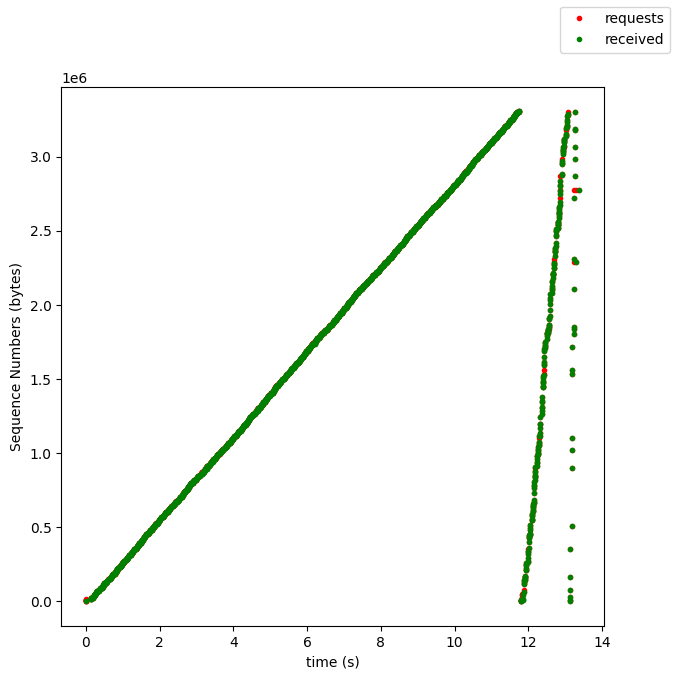

In [110]:
fig,ax = plt.subplots(figsize=(7,7),sharex=True,sharey=True);
plt.xlabel("time (s)");
plt.ylabel("Sequence Numbers (bytes)")
ax.plot(request_arr[0], request_arr[1], 'r.', label='requests');
ax.plot(receive_arr[0], receive_arr[1], 'g.', label='received');
fig.legend()

broke at i =  148
broke at i =  218
[177, 256] [148, 218]


D:\temp\ipykernel_1488\2020697016.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


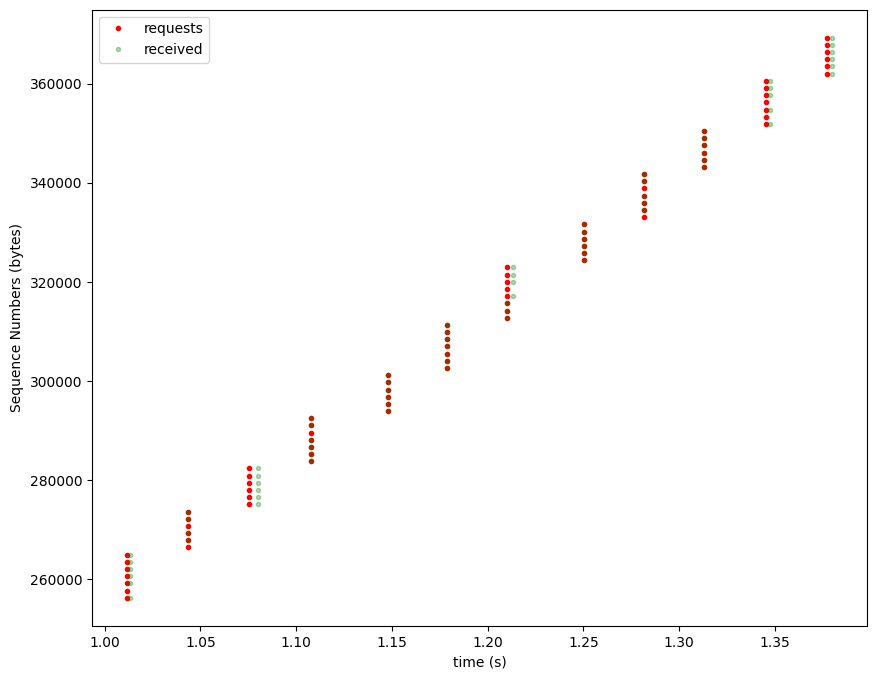

In [111]:
zoom_range = [1, 1.4]; 
req_range = [0,0]; recv_range = [0,0]
for j in [0,1]:
    for i in range(len(receive_arr[0])):
        if(request_arr[0][i] > zoom_range[j]):
            req_range[j] = i; 
            break;
    for i in range(len(request_arr[0])):
        if(receive_arr[0][i] > zoom_range[j]):
            recv_range[j] = i; 
            print("broke at i = ", i)
            break;

print(req_range, recv_range); 
fig, ax = plt.subplots(figsize=(10,8),sharex=True,sharey=True);
plt.xlabel("time (s)");
plt.ylabel("Sequence Numbers (bytes)") 
ax.plot(request_arr[0][req_range[0]:req_range[1]], request_arr[1][req_range[0]:req_range[1]], 'r.', label='requests');
ax.plot(receive_arr[0][recv_range[0]:recv_range[1]], receive_arr[1][recv_range[0]:recv_range[1]], 'g.', label='received', alpha=0.3);
ax.legend()
fig.show(); 

In [53]:
print(receive_arr[0][79])
print(receive_arr[1][79])
print(request_arr[0][92])
print(request_arr[1][92])

1.5854792594909668
114392
1.585223913192749
114392
